## BTC - EUR

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt
from matplotlib import pyplot
import matplotlib.dates as mdates

In [2]:
exchange = pd.read_csv("exchange_v2.csv")
exchange.head()

,date,Open,High,Low,Close,Adj Close,Volume,currency
0,2014-09-17,1.295908,1.298000,1.294090,1.295908,1.295908,0,EURUSD=X
1,2014-09-18,1.285017,1.292689,1.285017,1.285000,1.285000,0,EURUSD=X
2,2014-09-19,1.292140,1.292959,1.283203,1.292006,1.292006,0,EURUSD=X
3,2014-09-22,1.284076,1.286900,1.281953,1.284142,1.284142,0,EURUSD=X
4,2014-09-23,1.285298,1.289930,1.284589,1.285149,1.285149,0,EURUSD=X


### Plotting the data

In [3]:
btceur = exchange.loc[exchange['currency'] == 'BTC-EUR']

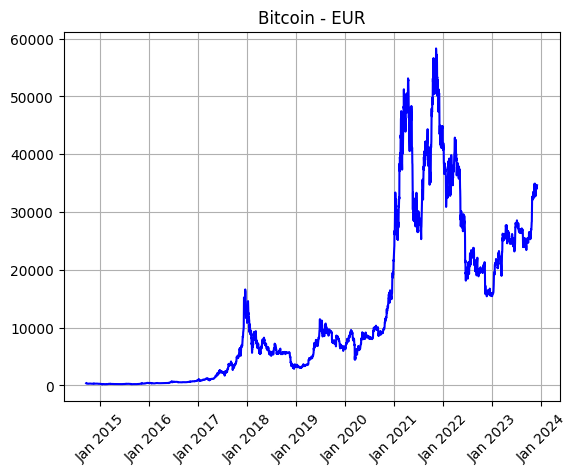

In [4]:
# Plotting the data as a time series index
plt.plot(pd.to_datetime(btceur['date']), btceur['Close'],color='blue', linestyle='-')

plt.title('Bitcoin - EUR')
plt.grid(True)

# Set the date format for x-axis ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Specify the frequency of ticks for months
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Rotate the x-axis labels for better readability (optional)
plt.xticks(rotation=45)

plt.show()

### Autocorrelation and Partial Autocorrelation

In [10]:
# Looks for null in the data
btceur.isnull().sum()

date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
currency     0
dtype: int64

In [12]:
acorr = sm.tsa.acf(btceur['Close'], nlags = 3362)

# Lags in terms of 1 day, 1 month, 1 quarter, 1 year, 2 years, 5 years, and last lag
lags_of_interest = [0, 1, 30, 90, 365, 730, 1825, 3362]

# Print autocorrelations for specified lags
for lag in lags_of_interest:
    print(f'Lag {lag} ({lag} days): {acorr[lag]}')

Lag 0 (0 days): 1.0
Lag 1 (1 days): 0.9983926739688632
Lag 30 (30 days): 0.9488925659805253
Lag 90 (90 days): 0.8357272488655484
Lag 365 (365 days): 0.481055904905671
Lag 730 (730 days): 0.22925363760792064
Lag 1825 (1825 days): -0.27606389479265137
Lag 3362 (3362 days): -0.0004093758165514663


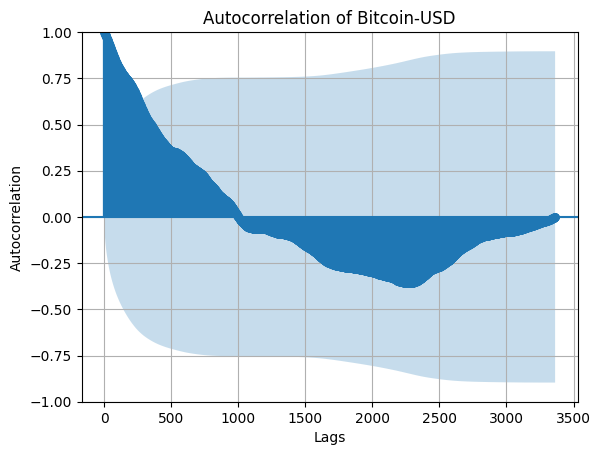

In [9]:
#Autocorrelation (3362 lags = +-10 years)
plot_acf(x = btceur['Close'], lags=3362, alpha=0.05)
plt.title('Autocorrelation of Bitcoin-USD')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

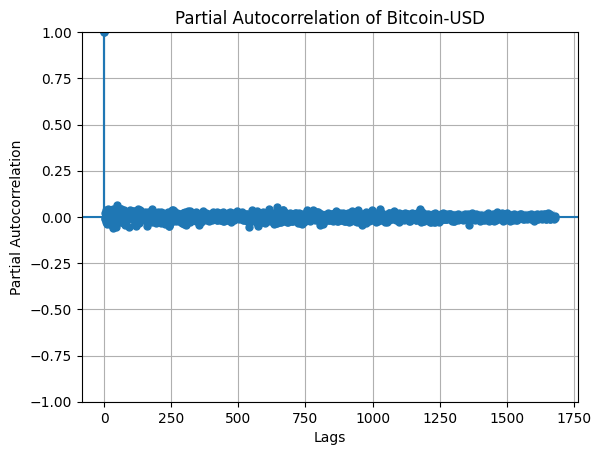

In [17]:
# Plot PACF
plot_pacf(btceur['Close'], lags=1680)
plt.title('Partial Autocorrelation of Bitcoin-USD')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

### First Differencing the Data

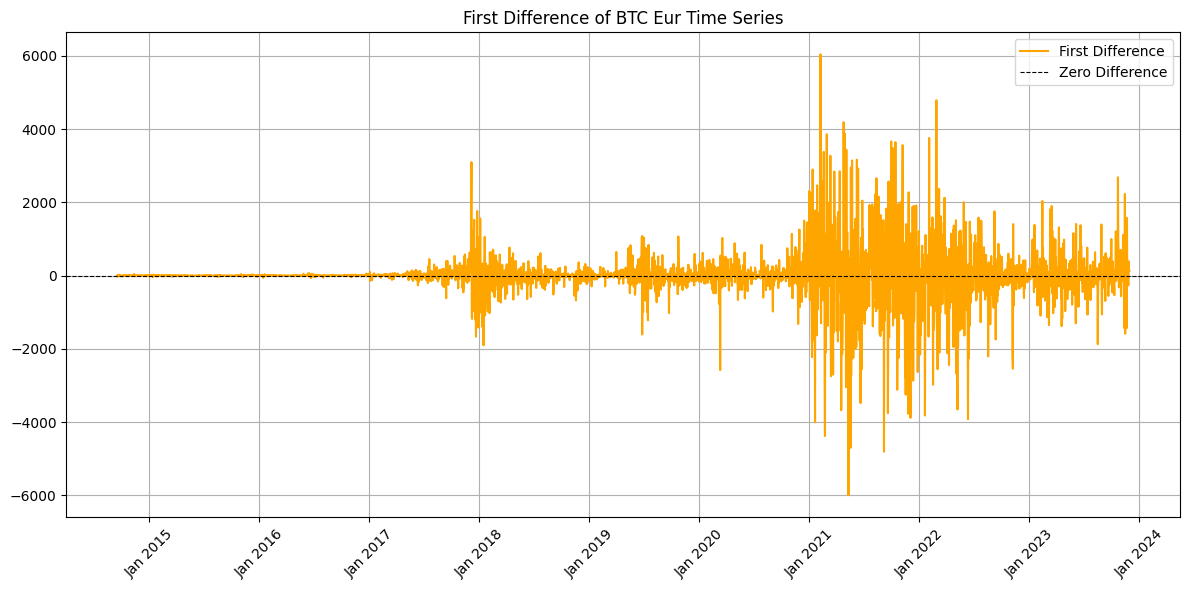

In [29]:
# Calculate the first difference
btceur_diff = btceur.copy()
btceur_diff['diff'] = pd.Series.diff(btceur_diff['Close'])
btceur_diff.fillna(0, inplace=True)

# Plot only the first difference
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(btceur_diff['date']), btceur_diff['diff'], label='First Difference', color='orange')
plt.title('First Difference of BTC Eur Time Series')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8, label='Zero Difference')
plt.legend()
plt.grid(True)

# Set the date format for x-axis ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Specify the frequency of ticks for months
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


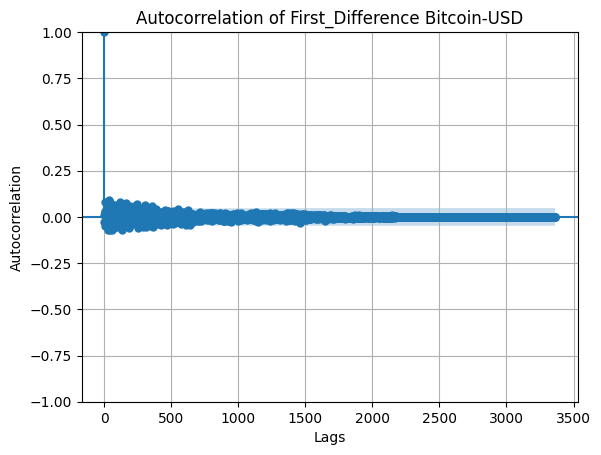

In [30]:
## ACF and PACF for the first difference
#Autocorrelation (3362 lags = +-10 years)
plot_acf(x = btceur_diff['diff'], lags=3362, alpha=0.05)
plt.title('Autocorrelation of First_Difference Bitcoin-USD')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

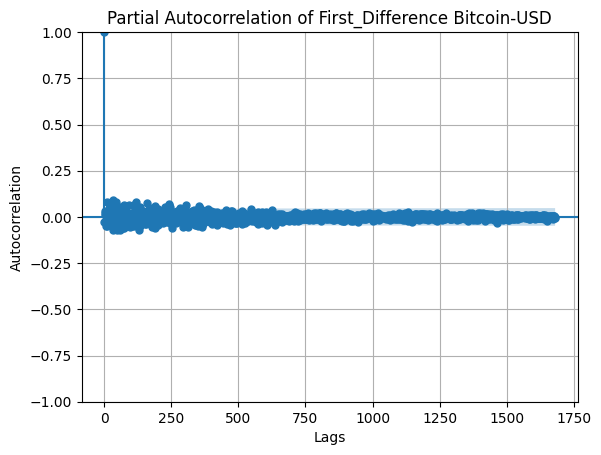

In [31]:
# Partial Autocorrelation 
plot_acf(x = btceur_diff['diff'], lags=1680)
plt.title('Partial Autocorrelation of First_Difference Bitcoin-USD')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

### Fit ARIMA model

/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


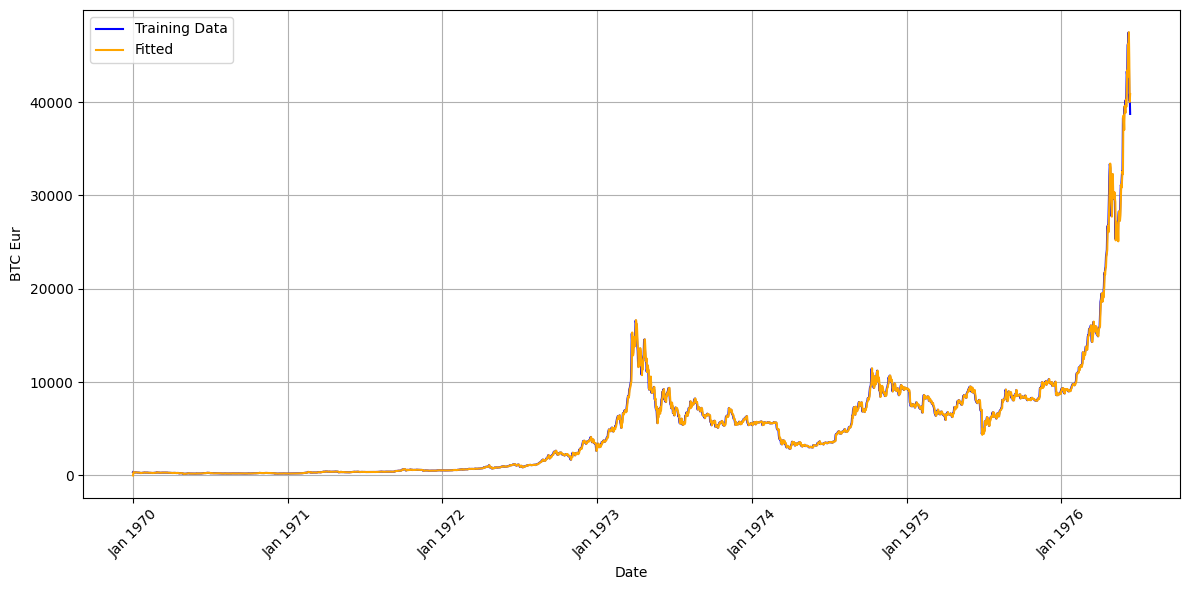

In [44]:
# Fit ARIMA model
# Split the data into training (70%) and testing (30%)
train_size = int(len(btceur) * 0.7)
train, test = btceur[:train_size], btceur[train_size:]

order = (0, 1, 1)  # Example order, you may need to tune these parameters
model = ARIMA(train['Close'], order=order)
model_fit = model.fit()
fit1 = model_fit.fittedvalues

# Plotting
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(train['date'], train['Close'], label='Training Data', color='blue')

# Plot fitted values
plt.plot(train['date'], fit1, label='Fitted', color='orange')

plt.xlabel('Date')
plt.ylabel('BTC Eur')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [45]:
#AIC of the model
aic = model_fit.aic
aic

34607.99083845738

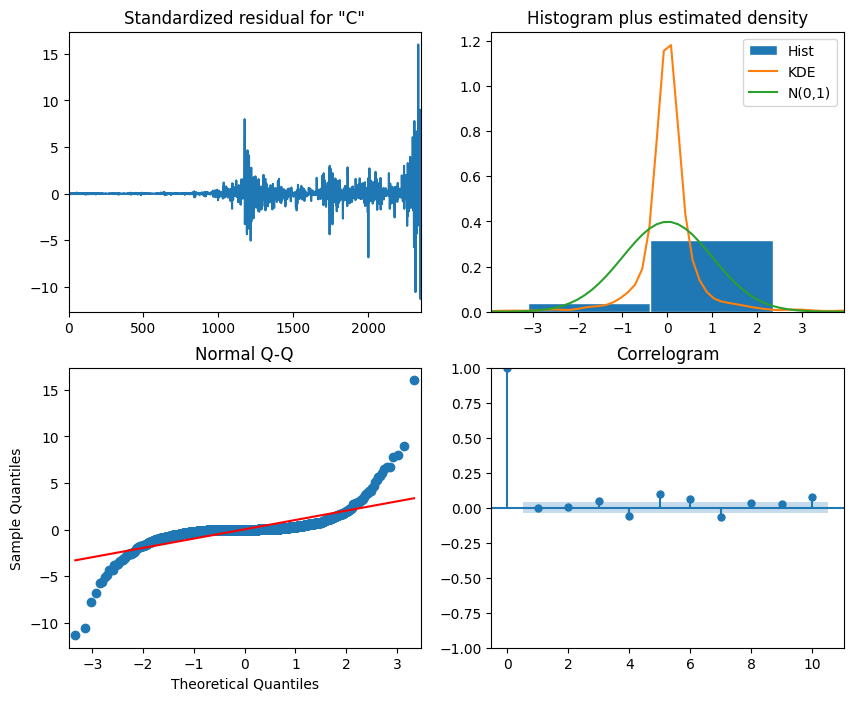

In [46]:
model_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

In [41]:
### Rolling forecast

Mean Squared Error (MSE): 1147183.6840392265


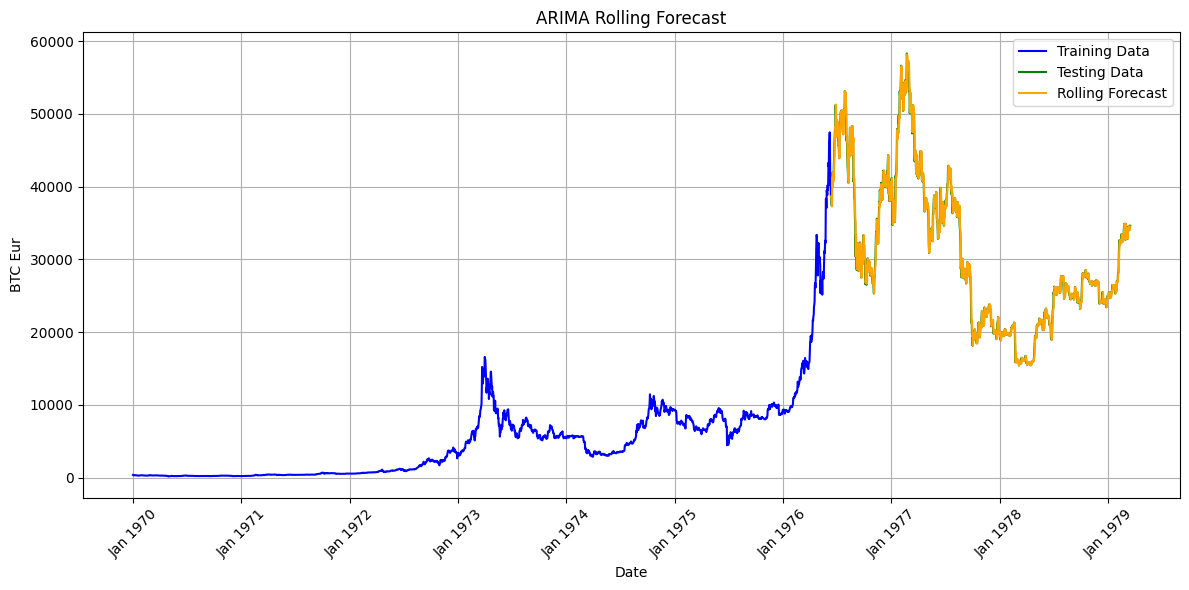

In [51]:
# Perform rolling forecast on the test set
rolling_forecast = []
train_data = train['Close'].to_list()

for i in range(len(test)):
    model = ARIMA(train_data, order=(0, 1, 1))
    model_fit = model.fit()
    output = model_fit.forecast(steps=1)
    yhat = output[0]
    rolling_forecast.append(yhat)
    obs = test['Close'].iloc[i]
    train_data.append(obs)

Mean Squared Error (MSE): 1071.0666104585775


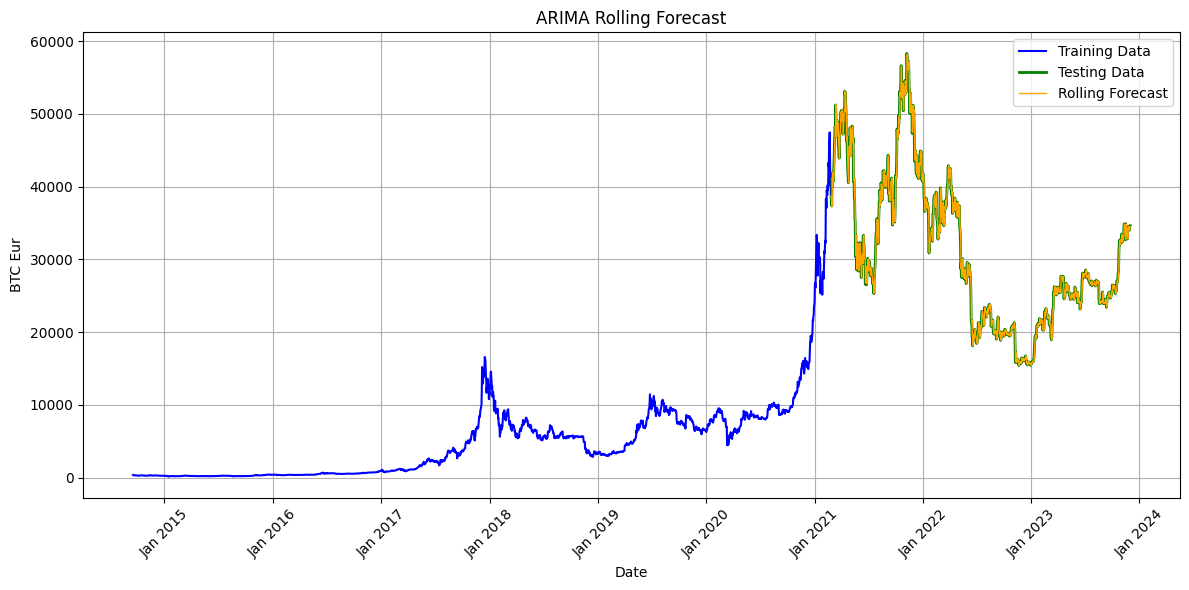

In [63]:

# Calculate Mean Squared Error (MSE) for the rolling forecast
rmse = sqrt(mean_squared_error(test['Close'], rolling_forecast))
print(f'Mean Squared Error (MSE): {rmse}')


# Plotting
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(pd.to_datetime(train['date']), train['Close'], label='Training Data', color='blue')

# Plot testing data
plt.plot(pd.to_datetime(test['date']), test['Close'], label='Testing Data', color='green', linewidth=2)

# Plot rolling forecast with adjusted color and size
plt.plot(pd.to_datetime(test['date']), rolling_forecast, label='Rolling Forecast', color='orange', linewidth=1)

plt.title('ARIMA Rolling Forecast')
plt.xlabel('Date')
plt.ylabel('BTC Eur')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()